In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import spherical_jn

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

In [2]:
# Generate matter power spectrum
params = {'output': 'mPk',
          'n_s': 0.965, 
          'H0': 67.4,
          'omega_b': 0.0224,
          'omega_cdm': 0.12,
          'tau_reio': 0.054,
          'sigma8': 0.811,
          'P_k_max_1/Mpc': 10}

cosmo = Class()
cosmo.set(params)

cosmo.compute()

z = 0
k = np.linspace(0.001, 10, 50000)
pk = [cosmo.pk(ki, z) for ki in k]

## Plot integrands in Eqs. 6-8

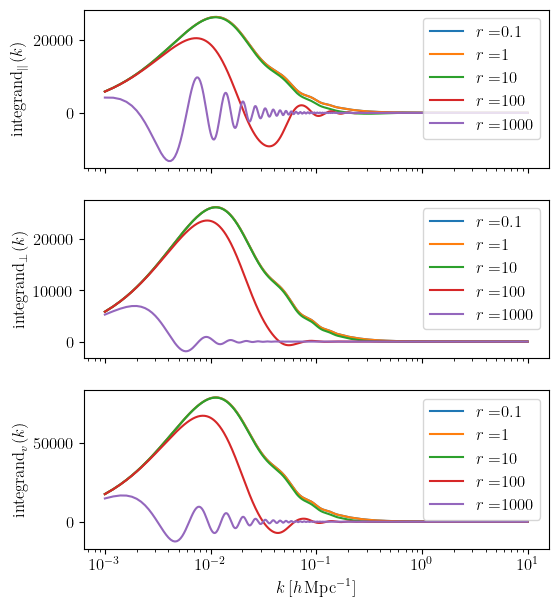

In [3]:
def integrand_para(r):
    return pk * (spherical_jn(0, k*r) - (2/(k*r)) * spherical_jn(1, k*r))
def integrand_perp(r):
    return pk * spherical_jn(1, k*r) / (k*r)
def integrand_v(r):
    return pk * spherical_jn(0, k*r)

r_values = [0.1, 1, 10, 100, 1000]

fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True)
fig.set_figheight(7)

ax = axs[0]
for r in r_values:
    ax.plot(k, integrand_para(r), label=r'$r=$'+str(r))
ax.legend(loc='upper right')
ax.set_ylabel(r'integrand$_\parallel(k)$')

ax = axs[1]
for r in r_values:
    ax.plot(k, integrand_perp(r), label=r'$r=$'+str(r))
ax.legend(loc='upper right')
ax.set_ylabel(r'integrand$_\perp(k)$')


ax = axs[2]
for r in r_values:
    ax.plot(k, integrand_v(r), label=r'$r=$'+str(r))
ax.legend(loc='upper right')
ax.set_ylabel(r'integrand$_v(k)$')
ax.set_xlabel(r'$k \, [h \, \mathrm{Mpc}^{-1}]$')

for ax in axs:
    ax.set_xscale('log')

The $r=0.1, 1, 10$ curves overlap almost completely.

## Compute $\dot D\equiv \mathrm{d}D/\mathrm{d}\tau$

$$\frac{\mathrm{d}D}{\mathrm{d}\tau}
=\frac{\mathrm{d}D}{\mathrm{d}a} \frac{\mathrm{d}a}{\mathrm{d}t} \frac{\mathrm{d}t}{\mathrm{d}\tau}
=\frac{\mathrm{d}D}{\mathrm{d}a} \cdot aH \cdot a$$

In [4]:
Omega_m0 = 0.31
Omega_L0 = 1. - Omega_m0

a = np.linspace(0.01, 1., 1000)
z = 1 / a - 1

def H(a):
    return np.sqrt(Omega_m0 * a**-3 + Omega_L0)

def D(a):
    integral = np.trapezoid(1 / (a**3 * (H(a))**3), a)
    D = 5 / 2 * Omega_m0 * H(a) * integral
    D_normalized = D / D[-1]
    return D_normalized

def D_approx(a):
    D_approx = 5 / 2 * a * Omega_m0 / (Omega_m0**(4/7) - Omega_L0 + (1 + Omega_m0/2) * (1 + Omega_L0/70))
    D_approx_normalized = D_approx / D_approx[-1]
    return D_approx_normalized

def dD_dtau(D, a):
    dD_da = np.gradient(D, a)
    return dD_da * a**2 * H(a)

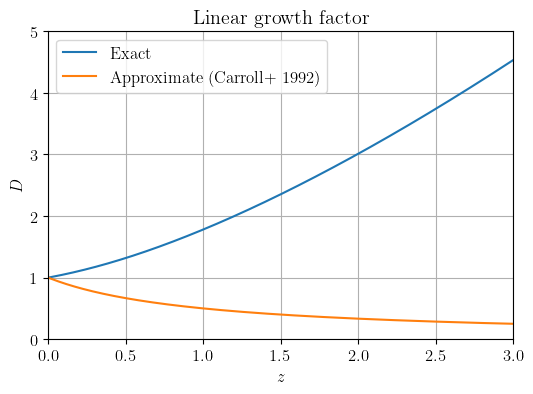

In [5]:
D_vals = D(a)
D_approx_vals = D_approx(a)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(z, D_vals, label='Exact')
ax.plot(z, D_approx_vals, label='Approximate (Carroll+ 1992)')
ax.set_xbound(0, 3)
ax.set_ybound(0, 5)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$D$')
ax.set_title('Linear growth factor')
ax.grid(True)
ax.legend(loc='upper left')

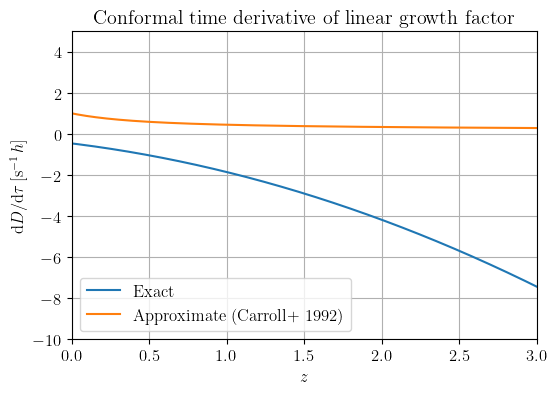

In [6]:
dD_dtau_vals = dD_dtau(D(a), a)
dD_dtau_approx_vals = dD_dtau(D_approx(a), a)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(z, dD_dtau_vals, label='Exact')
ax.plot(z, dD_dtau_approx_vals, label='Approximate (Carroll+ 1992)')

ax.set_xbound(0, 3)
ax.set_ybound(-10, 5)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r"$\mathrm{d}D/\mathrm{d}\tau\,[\mathrm{s}^{-1}\,h]$")
ax.set_title("Conformal time derivative of linear growth factor")
ax.grid(True)
ax.legend(loc='lower left')

## Plot correlations (Eqs. 6-8)

In [7]:
D_dot = dD_dtau_vals[-1] # Linear perturbation growth factor
r_array = np.linspace(0.1, 1000, 10000)

Text(0, 0.5, '$\\xi(r)\\,[\\mathrm{Mpc}^2\\,h^{-2}\\,\\mathrm{s}^{-2}]$')

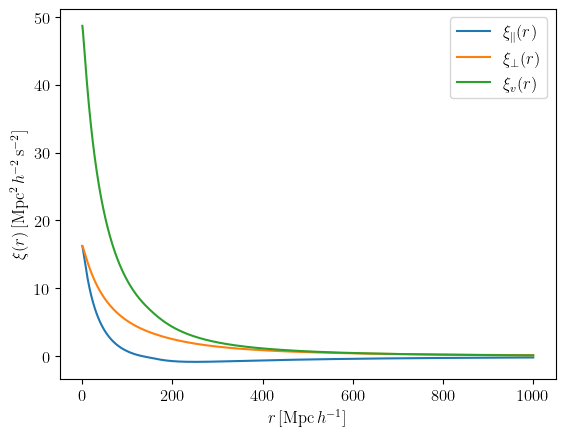

In [8]:
def xi_para(r):
    integrand = integrand_para(r)
    return D_dot**2 / (2 * np.pi**2) * np.trapezoid(integrand, k)
xi_para = [xi_para(r) for r in r_array]

def xi_perp(r):
    integrand = integrand_perp(r)
    return D_dot**2 / (2 * np.pi**2) * np.trapezoid(integrand, k)
xi_perp = [xi_perp(r) for r in r_array]

def xi_v(r):
    integrand = integrand_v(r)
    return D_dot**2 / (2 * np.pi**2) * np.trapezoid(integrand, k)
xi_v = [xi_v(r) for r in r_array]

fig, ax = plt.subplots(1, 1, sharex=True)
ax.plot(r_array, xi_para, label=r'$\xi_\parallel(r)$')
ax.plot(r_array, xi_perp, label=r'$\xi_\perp(r)$')
ax.plot(r_array, np.asarray(xi_v), label=r'$\xi_v(r)$')
ax.legend()
ax.set_xlabel(r'$r\,[\mathrm{Mpc}\,h^{-1}]$')
ax.set_ylabel(r'$\xi(r)\,[\mathrm{Mpc}^2\,h^{-2}\,\mathrm{s}^{-2}]$')